In [31]:
%reload_ext blackcellmagic
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from qflow.wavefunctions import RBMWavefunction as RBM
from qflow.wavefunctions import RBMSymmetricWavefunction as SRBM
from qflow.wavefunctions import (
    JastrowPade,
    JastrowOrion,
    SimpleGaussian,
    WavefunctionProduct,
    FixedWavefunction,
    Dnn,
    SumPooling,
    InputSorter
)
from qflow.wavefunctions.nn.layers import DenseLayer
from qflow.wavefunctions.nn.activations import sigmoid, tanh, relu, identity, exponential

from qflow.hamiltonians import (
    HarmonicOscillator,
    CoulombHarmonicOscillator,
)

from qflow.samplers import MetropolisSampler, ImportanceSampler
from qflow.optimizers import AdamOptimizer, SgdOptimizer
from qflow.training import train, EnergyCallback, SymmetryCallback, ParameterCallback
from qflow.statistics import compute_statistics_for_series


def plot_training(energies, symmetries, parameters):
    fig, (eax, sax, pax) = plt.subplots(ncols=3, figsize=(16, 4))
    eax.plot(energies, label=r"$\langle E_L\rangle$ [a.u]")
    sax.semilogx(symmetries, label=r"$S(\Psi)$")
    pax.plot(parameters)
    eax.legend()
    sax.legend()


# Ideal Harmonic Oscillator


In [2]:
H0 = HarmonicOscillator()


In [3]:
P, D = 2, 2  # Particles, dimensions
N = 2  # Hidden nodes
system = np.empty((P, D))


## SimpleGaussian


In [4]:
psi = SimpleGaussian(alpha=0.8)
psi_sampler = ImportanceSampler(system, psi, step_size=0.1)


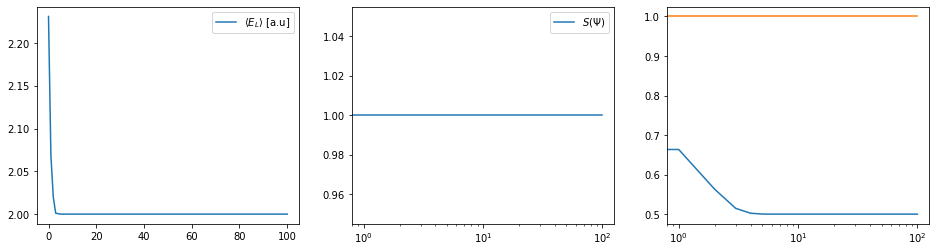

In [5]:
psi_energies = EnergyCallback(samples=5000)
psi_symmetries = SymmetryCallback(samples=100)
psi_parameters = ParameterCallback()

train(
    psi,
    H0,
    psi_sampler,
    iters=15000,
    samples=500,
    gamma=0,
    optimizer=AdamOptimizer(len(psi.parameters)),
    call_backs=(psi_energies, psi_symmetries, psi_parameters),
)
plot_training(psi_energies, psi_symmetries, psi_parameters)


In [7]:
compute_statistics_for_series(
    H0.local_energy_array(psi_sampler, psi, 2 ** 20), method="blocking"
)

{'mean': 2.000000000000185,
 'max': 2.00000000003472,
 'min': 1.9999999999368658,
 'var': 1.6760935611483924e-22,
 'std': 1.294640321150393e-11,
 'sem': 2.0231224800661338e-13,
 'CI': (1.9999999999997886, 2.0000000000005818)}

## SimpleGaussian with Orion Jastrow


In [8]:
simple_gaussian = SimpleGaussian(alpha=0.5)
jastrow = JastrowOrion(beta=1, gamma=0)
psi = WavefunctionProduct(simple_gaussian, jastrow)
psi_sampler = ImportanceSampler(system, psi, step_size=0.1)


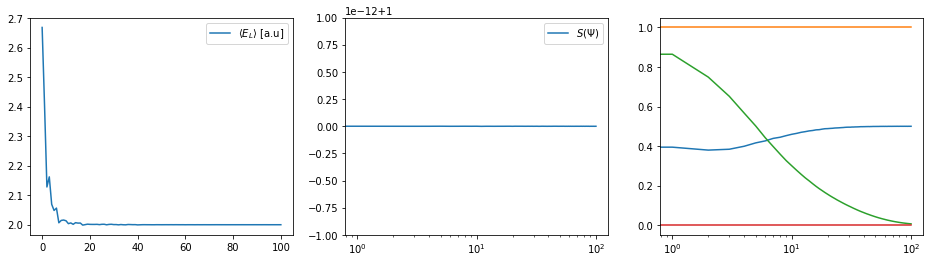

In [9]:
psi_energies = EnergyCallback(samples=5000)
psi_symmetries = SymmetryCallback(samples=100)
psi_parameters = ParameterCallback()

train(
    psi,
    H0,
    psi_sampler,
    iters=15000,
    samples=500,
    gamma=0,
    optimizer=AdamOptimizer(len(psi.parameters)),
    call_backs=(psi_energies, psi_symmetries, psi_parameters),
)
plot_training(psi_energies, psi_symmetries, psi_parameters)


In [10]:
compute_statistics_for_series(
    H0.local_energy_array(psi_sampler, psi, 2 ** 20), method="blocking"
)

{'mean': 2.0000001144747253,
 'max': 2.0000503911733594,
 'min': 1.999967599216819,
 'var': 1.5876202475402492e-10,
 'std': 1.2600080347125764e-05,
 'sem': 2.784930703036335e-07,
 'CI': (1.999999568315404, 2.0000006606340466)}

## Non-symmetric RBM


In [11]:
rbm = RBM(P * D, N)
rbm_sampler = ImportanceSampler(system, rbm, step_size=0.1)


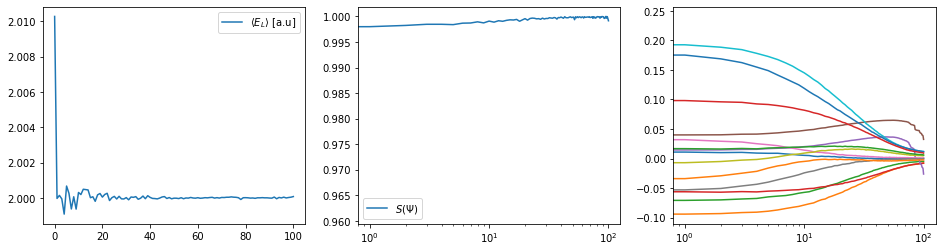

In [12]:
rbm_energies = EnergyCallback(samples=5000)
rbm_symmetries = SymmetryCallback(samples=10000)
rbm_parameters = ParameterCallback()

train(
    rbm,
    H0,
    rbm_sampler,
    iters=15000,
    samples=500,
    gamma=0,
    optimizer=AdamOptimizer(len(rbm.parameters)),
    call_backs=(rbm_energies, rbm_symmetries, rbm_parameters),
)
plot_training(rbm_energies, rbm_symmetries, rbm_parameters)


In [13]:
compute_statistics_for_series(
    H0.local_energy_array(rbm_sampler, rbm, 2 ** 20), method="blocking"
)

{'mean': 1.9999995667258377,
 'max': 2.00066882236022,
 'min': 1.999258265967689,
 'var': 4.7790962864093695e-08,
 'std': 0.0002186114426650483,
 'sem': 4.831855844886254e-06,
 'CI': (1.9999900908595023, 2.000009042592173)}

## Symmetric RBM


In [14]:
srbm = SRBM(P * D, N, D)
srbm_sampler = ImportanceSampler(system, srbm, step_size=0.1)


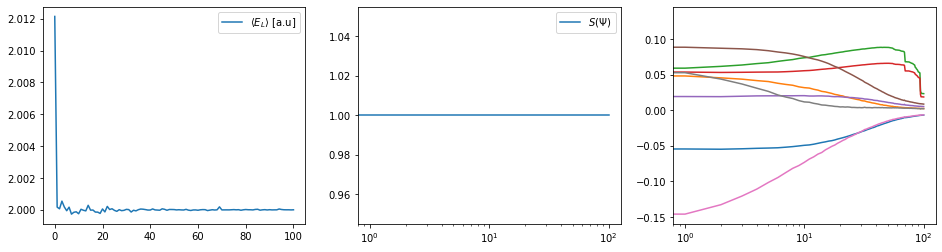

In [15]:
srbm_energies = EnergyCallback(samples=5000)
srbm_symmetries = SymmetryCallback(samples=10000)
srbm_parameters = ParameterCallback()

train(
    srbm,
    H0,
    srbm_sampler,
    iters=15000,
    samples=500,
    gamma=0,
    optimizer=AdamOptimizer(len(srbm.parameters)),
    call_backs=(srbm_energies, srbm_symmetries, srbm_parameters),
)
plot_training(srbm_energies, srbm_symmetries, srbm_parameters)


In [17]:
compute_statistics_for_series(
    H0.local_energy_array(srbm_sampler, srbm, 2 ** 20), method="blocking"
)

{'mean': 2.0000002890669184,
 'max': 2.0000503110420143,
 'min': 1.999968810958801,
 'var': 1.4365830536418115e-10,
 'std': 1.1985754267637108e-05,
 'sem': 2.649149381543876e-07,
 'CI': (1.999999769535992, 2.000000808597845)}

# Quantum Dots


In [2]:
H1 = CoulombHarmonicOscillator()


In [3]:
P, D = 2, 2  # Particles, dimensions
N = 4  # Hidden nodes
system = np.empty((P, D))


## SimpleGaussian with Pade Jastrow


In [23]:
simple_gaussian = SimpleGaussian(alpha=0.5)
jastrow = JastrowPade(alpha=1, beta=1)
psi = WavefunctionProduct(simple_gaussian, jastrow)
psi_sampler = ImportanceSampler(system, psi, step_size=0.1)


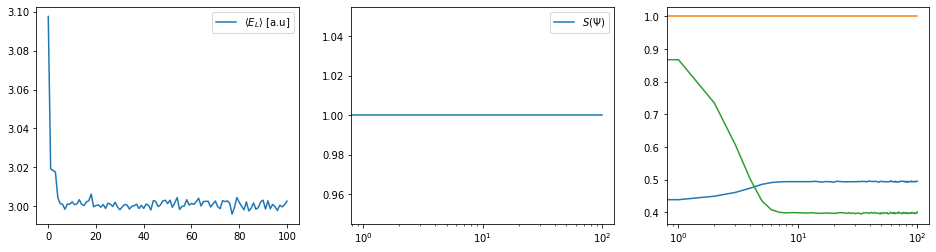

In [24]:
psi_energies = EnergyCallback(samples=5000)
psi_symmetries = SymmetryCallback(samples=100)
psi_parameters = ParameterCallback()

train(
    psi,
    H1,
    psi_sampler,
    iters=15000,
    samples=1000,
    gamma=0,
    optimizer=AdamOptimizer(len(psi.parameters)),
    call_backs=(psi_energies, psi_symmetries, psi_parameters),
)
plot_training(psi_energies, psi_symmetries, psi_parameters)


In [25]:
compute_statistics_for_series(
    H1.local_energy_array(psi_sampler, psi, 2 ** 20), method="blocking"
)

{'mean': 3.0006805263784724,
 'max': 3.02076958870808,
 'min': 2.963227115499874,
 'var': 5.0912371903993024e-05,
 'std': 0.007135290597024975,
 'sem': 0.00011150252755775874,
 'CI': (3.0004619208270604, 3.0008991319298843)}

## SimpleGaussian with Orion Jastrow


In [26]:
simple_gaussian = SimpleGaussian(alpha=0.5)
jastrow = JastrowOrion(beta=2, gamma=1.5)
psi = WavefunctionProduct(simple_gaussian, jastrow)
psi_sampler = ImportanceSampler(system, psi, step_size=0.1)


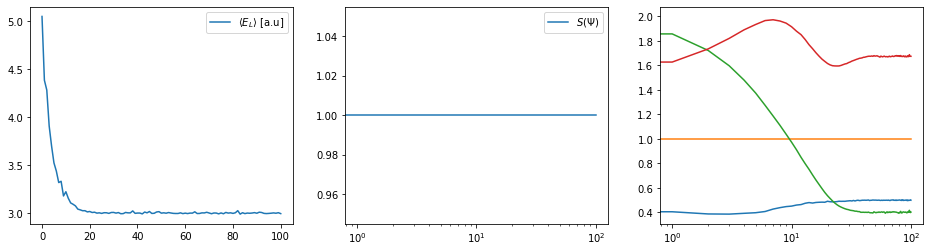

In [27]:
psi_energies = EnergyCallback(samples=5000)
psi_symmetries = SymmetryCallback(samples=100)
psi_parameters = ParameterCallback()

train(
    psi,
    H1,
    psi_sampler,
    iters=15000,
    samples=1000,
    gamma=0,
    optimizer=AdamOptimizer(len(psi.parameters)),
    call_backs=(psi_energies, psi_symmetries, psi_parameters),
)
plot_training(psi_energies, psi_symmetries, psi_parameters)


In [28]:
compute_statistics_for_series(
    H1.local_energy_array(psi_sampler, psi, 2 ** 20), method="blocking"
)

{'mean': 3.001848713322728,
 'max': 8.51928392424486,
 'min': 2.759966643616751,
 'var': 0.004778256660663951,
 'std': 0.06912493515847919,
 'sem': 0.0005400550373489031,
 'CI': (3.0007901466937827, 3.002907279951673)}

## Non-symmetric RBM


In [4]:
rbm = RBM(P * D, N)
rbm_sampler = ImportanceSampler(system, rbm, step_size=0.1)


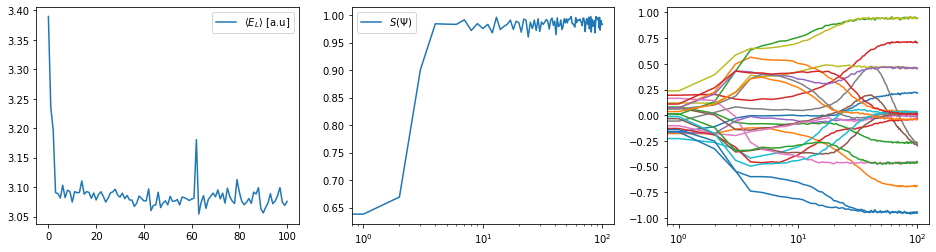

In [5]:
rbm_energies = EnergyCallback(samples=50000)
rbm_symmetries = SymmetryCallback(samples=10000)
rbm_parameters = ParameterCallback()

train(
    rbm,
    H1,
    rbm_sampler,
    iters=50000,
    samples=2000,
    gamma=0.0001,
    optimizer=AdamOptimizer(len(rbm.parameters)),
    call_backs=(rbm_energies, rbm_symmetries, rbm_parameters),
)
plot_training(rbm_energies, rbm_symmetries, rbm_parameters)


In [95]:
compute_statistics_for_series(
    H1.local_energy_array(rbm_sampler, rbm, 2 ** 22), method="blocking"
)

{'mean': 3.079787130131568,
 'max': 9.632575985120955,
 'min': 2.7377925375909697,
 'var': 0.028318899622329308,
 'std': 0.16828220233384547,
 'sem': 0.0013147448291734509,
 'CI': (3.0772100872276202, 3.0823641730355154)}

In [ ]:
a = rbm.parameters[: P * D]
b = rbm.parameters[P * D : P * D + N]
w = rbm.parameters[P * D + N :].reshape(P * D, N)
a, b, w


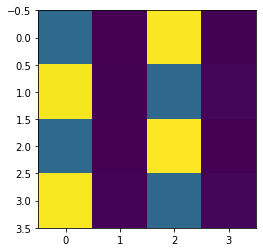

In [ ]:
plt.imshow(np.abs(w))


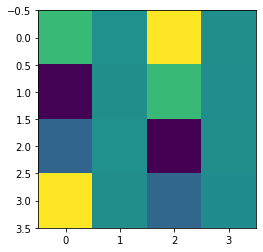

In [ ]:
plt.imshow(w)


In [ ]:
srbm.parameters = rbm.parameters

## RBM + InputSorter


In [6]:
rbm_underlying = RBM(P * D, N)
srbm = InputSorter(rbm_underlying)
srbm.parameters = rbm.parameters
srbm_sampler = ImportanceSampler(system, srbm, step_size=0.1)
srbm_sampler.thermalize(5000)
srbm_sampler.acceptance_rate

0.9904

In [90]:
srbm_energies = EnergyCallback(samples=500000, verbose=True)
srbm_symmetries = SymmetryCallback(samples=100)
srbm_parameters = ParameterCallback()

train(
    srbm,
    H1,
    srbm_sampler,
    iters=40000,
    samples=5000,
    gamma=0.0001,
    optimizer=AdamOptimizer(len(srbm.parameters)),
    call_backs=(srbm_energies, srbm_symmetries, srbm_parameters),
)

EnergyCallback(iter=0): 3.273605451865663
EnergyCallback(iter=400): 3.211916901336611
EnergyCallback(iter=800): 3.188574169108206
EnergyCallback(iter=1200): 3.1829654424156497
EnergyCallback(iter=1600): 3.156253520840504
EnergyCallback(iter=2000): 3.1615309090625403
EnergyCallback(iter=2400): 3.16835321959083
EnergyCallback(iter=2800): 3.1603534996646783
EnergyCallback(iter=3200): 3.161849374993328
EnergyCallback(iter=3600): 3.160587452358056
EnergyCallback(iter=4000): 3.1551439317067027
EnergyCallback(iter=4400): 3.158843181887389
EnergyCallback(iter=4800): 3.1569889840064445
EnergyCallback(iter=5200): 3.1548618394156898
EnergyCallback(iter=5600): 3.1619082363604605
EnergyCallback(iter=6000): 3.1494559086984246
EnergyCallback(iter=6400): 3.157667899630969
EnergyCallback(iter=6800): 3.154689876476842
EnergyCallback(iter=7200): 3.1558981567865017
EnergyCallback(iter=7600): 3.154686851972625
EnergyCallback(iter=8000): 3.1650403262919147
EnergyCallback(iter=8400): 3.158162549564833
Energy

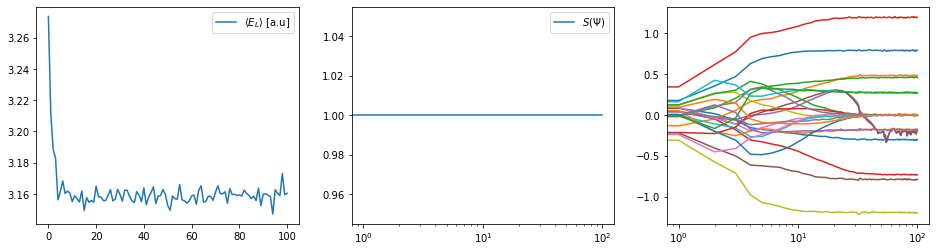

In [91]:
plot_training(srbm_energies, srbm_symmetries, srbm_parameters)

In [7]:
compute_statistics_for_series(
    H1.local_energy_array(srbm_sampler, srbm, 2**21),
    method="blocking",
)


{'mean': 3.0779511021675656,
 'max': 5.02607745004016,
 'min': 2.835703688822846,
 'var': 0.01259191517905116,
 'std': 0.11221370316967157,
 'sem': 0.0017535531818776,
 'CI': (3.0745131849413783, 3.081389019393753)}

# Simple Gaussian + Pade + Dnn

In [36]:
simple_gaussian = SimpleGaussian(alpha=0.5)
jastrow = JastrowPade(alpha=1, beta=1)
layers = [
    DenseLayer(P * D, 32, activation=tanh, scale_factor=0.001),
    DenseLayer(32, 16, activation=tanh),
    DenseLayer(16, 1, activation=exponential),
]
dnn = Dnn()
for l in layers:
    dnn.add_layer(l)
simple_and_jastrow = WavefunctionProduct(simple_gaussian, jastrow)
psi = WavefunctionProduct(simple_and_jastrow, dnn)
psi_sampler = ImportanceSampler(system, psi, step_size=0.1)


In [30]:
s = psi_sampler.next_configuration()


In [31]:
%timeit H1.local_energy(s, psi)

46.3 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [32]:
%timeit H1.local_energy(s, simple_gaussian)

1.34 µs ± 17.6 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [33]:
%timeit H1.local_energy(s, jastrow)

1.33 µs ± 9.92 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [34]:
%timeit H1.local_energy(s, dnn)

28.3 µs ± 2.53 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


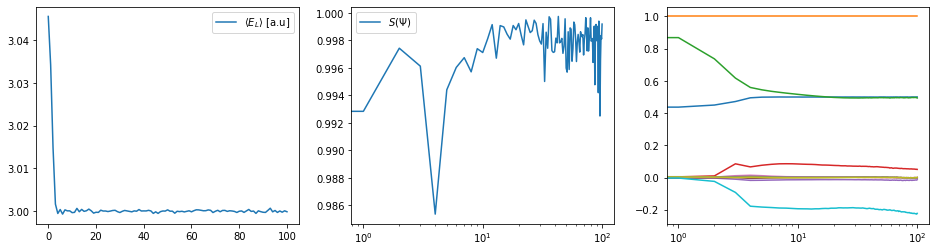

In [37]:
psi_energies = EnergyCallback(samples=5000, verbose=False)
psi_symmetries = SymmetryCallback(samples=100)
psi_parameters = ParameterCallback()

train(
    psi,
    H1,
    psi_sampler,
    iters=15000,
    samples=1000,
    gamma=0,
    optimizer=AdamOptimizer(len(psi.parameters)),
    call_backs=(psi_energies, psi_symmetries, psi_parameters),
)
plot_training(psi_energies, psi_symmetries, np.array(psi_parameters)[:, :10])


In [41]:
compute_statistics_for_series(
    H1.local_energy_array(psi_sampler, psi, 2 ** 21), method="blocking"
)

{'mean': 3.0000269607557186,
 'max': 3.0024175568419236,
 'min': 2.9970471191886205,
 'var': 3.9048416973739763e-07,
 'std': 0.0006248873256335079,
 'sem': 9.765056559293557e-06,
 'CI': (3.000007815937924, 3.0000461055735133)}

## Simple gaussian + Orion Jastrow + DNN


In [10]:
simple_gaussian = SimpleGaussian(alpha=0.5)
jastrow = JastrowOrion(beta=2, gamma=1.5)
layers = [
    DenseLayer(P * D, 32, activation=tanh, scale_factor=0.001),
    DenseLayer(32, 16, activation=tanh),
    DenseLayer(16, 1, activation=exponential),
]
dnn = Dnn()
for l in layers:
    dnn.add_layer(l)
simple_and_jastrow = WavefunctionProduct(simple_gaussian, jastrow)
psi = WavefunctionProduct(simple_and_jastrow, dnn)
psi_sampler = ImportanceSampler(system, psi, step_size=0.1)


In [30]:
s = psi_sampler.next_configuration()


In [36]:
%timeit H1.local_energy(s, psi)

76.2 µs ± 1.59 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
%timeit H1.local_energy(s, simple_gaussian)

2.69 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [38]:
%timeit H1.local_energy(s, jastrow)

2.76 µs ± 227 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [39]:
%timeit H1.local_energy(s, dnn)

48.6 µs ± 1.48 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


EnergyCallback(iter=0): 5.064143160666213
EnergyCallback(iter=150): 4.5981090091152526
EnergyCallback(iter=300): 4.244975096156259
EnergyCallback(iter=450): 3.8190334751838164
EnergyCallback(iter=600): 3.6115385393675337
EnergyCallback(iter=750): 3.5127188678153316
EnergyCallback(iter=900): 3.3793835150761513
EnergyCallback(iter=1050): 3.274190812960659
EnergyCallback(iter=1200): 3.249446820217353
EnergyCallback(iter=1350): 3.1772564314752185
EnergyCallback(iter=1500): 3.128175062998774
EnergyCallback(iter=1650): 3.1109599516715285
EnergyCallback(iter=1800): 3.108727445566955
EnergyCallback(iter=1950): 3.082510175571178
EnergyCallback(iter=2100): 3.0467498222945393
EnergyCallback(iter=2250): 3.0382028396995286
EnergyCallback(iter=2400): 3.0027287379529177
EnergyCallback(iter=2550): 3.0374146523092733
EnergyCallback(iter=2700): 3.004993977295975
EnergyCallback(iter=2850): 3.003176897930657
EnergyCallback(iter=3000): 3.0029624575460376
EnergyCallback(iter=3150): 3.0161326846339387
Energy

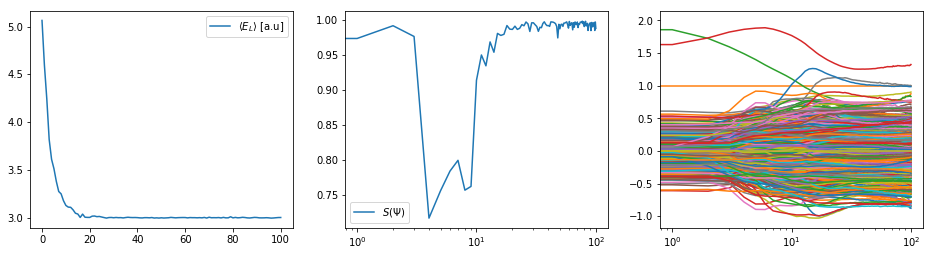

In [12]:
psi_energies = EnergyCallback(samples=5000, verbose=True)
psi_symmetries = SymmetryCallback(samples=100)
psi_parameters = ParameterCallback()

train(
    psi,
    H1,
    psi_sampler,
    iters=15000,
    samples=1000,
    gamma=0,
    optimizer=AdamOptimizer(len(psi.parameters)),
    call_backs=(psi_energies, psi_symmetries, psi_parameters),
)
plot_training(psi_energies, psi_symmetries, psi_parameters)


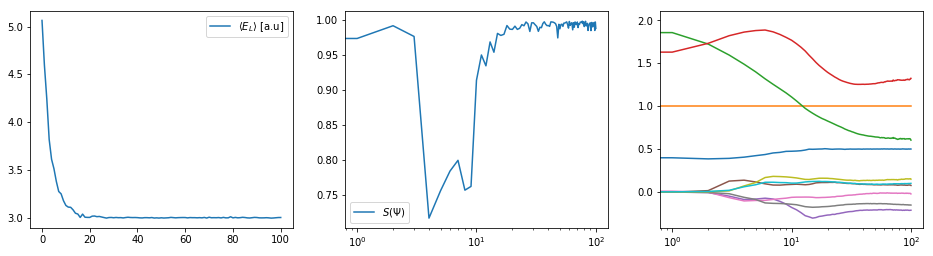

In [19]:
plot_training(psi_energies, psi_symmetries, np.array(psi_parameters)[:, :10])


In [24]:
compute_statistics_for_series(
    [H1.local_energy(psi_sampler.next_configuration(), psi) for _ in range(2 ** 21)],
    method="blocking",
)


{'mean': 2.999981552313362,
 'max': 3.9830328178782284,
 'min': 2.9360899513082344,
 'var': 0.00029693425152489173,
 'std': 0.017231780277292642,
 'sem': 0.000134627391980994,
 'CI': (2.9997176679781794, 3.000245436648545)}

In [25]:
abs(3 - 2.999981552313362)


1.8447686637834693e-05

In [23]:
"%e" % abs(3 - 3.0015273249412244)


'1.527325e-03'

## Simple gaussian + Jastrow + (DNN + SumPooling)


In [5]:
simple_gaussian = SimpleGaussian(alpha=0.5)
jastrow = JastrowOrion(beta=2, gamma=1.5)
layers = [
    DenseLayer(2 * D, 32, activation=tanh, scale_factor=0.001),
    DenseLayer(32, 16, activation=tanh),
    DenseLayer(16, 1, activation=exponential),
]
dnn = Dnn()
for l in layers:
    dnn.add_layer(l)
simple_and_jastrow = WavefunctionProduct(simple_gaussian, jastrow)
pooled_dnn = SumPooling(dnn)
psi = WavefunctionProduct(simple_and_jastrow, pooled_dnn)
psi_sampler = ImportanceSampler(system, psi, step_size=0.1)


In [6]:
s = psi_sampler.next_configuration()


In [7]:
%timeit H1.local_energy(s, psi)

211 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%timeit H1.local_energy(s, simple_gaussian)

2.77 µs ± 56.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [9]:
%timeit H1.local_energy(s, jastrow)

2.89 µs ± 74.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
%timeit H1.local_energy(s, dnn)

50.7 µs ± 1.93 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [12]:
%timeit H1.local_energy(s, pooled_dnn)

99.4 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
psi.symmetry_metric(psi_sampler, 10000)


1.0000000000000002

EnergyCallback(iter=0): 5.117594899770974
EnergyCallback(iter=150): 4.553767085543832
EnergyCallback(iter=300): 4.093402393930743
EnergyCallback(iter=450): 3.965756559261545
EnergyCallback(iter=600): 3.66274267249415
EnergyCallback(iter=750): 3.5062829153385486
EnergyCallback(iter=900): 3.3926010402575892
EnergyCallback(iter=1050): 3.2792110806276877
EnergyCallback(iter=1200): 3.272517979298609
EnergyCallback(iter=1350): 3.2106776486991286
EnergyCallback(iter=1500): 3.1968325595077447
EnergyCallback(iter=1650): 3.130023762248109
EnergyCallback(iter=1800): 3.103958401263992
EnergyCallback(iter=1950): 3.0159029562469075
EnergyCallback(iter=2100): 3.0674308671526016
EnergyCallback(iter=2250): 3.0179274627422856
EnergyCallback(iter=2400): 3.0266110389403855
EnergyCallback(iter=2550): 3.036488237522735
EnergyCallback(iter=2700): 3.0038422507244804
EnergyCallback(iter=2850): 2.997276389817471
EnergyCallback(iter=3000): 3.009112021232432
EnergyCallback(iter=3150): 3.013421243025421
EnergyCall

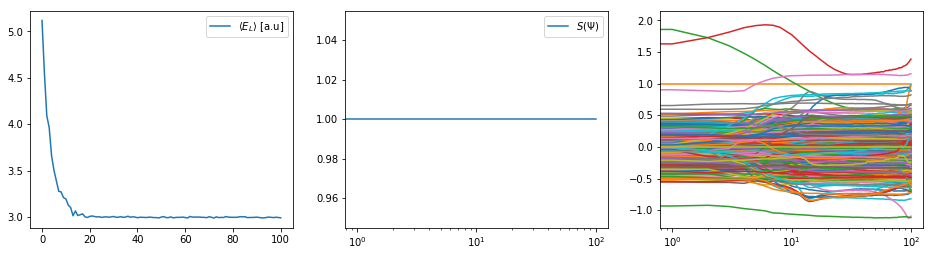

In [15]:
psi_energies = EnergyCallback(samples=5000, verbose=True)
psi_symmetries = SymmetryCallback(samples=100)
psi_parameters = ParameterCallback()

train(
    psi,
    H1,
    psi_sampler,
    iters=15000,
    samples=1000,
    gamma=0,
    optimizer=AdamOptimizer(len(psi.parameters)),
    call_backs=(psi_energies, psi_symmetries, psi_parameters),
)
plot_training(psi_energies, psi_symmetries, psi_parameters)


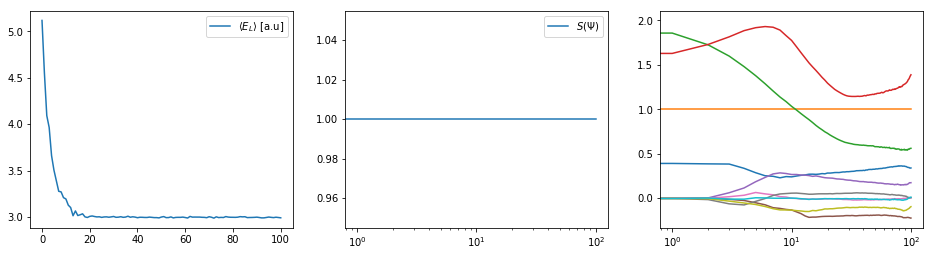

In [16]:
plot_training(psi_energies, psi_symmetries, np.array(psi_parameters)[:, :10])


In [17]:
compute_statistics_for_series(
    [H1.local_energy(psi_sampler.next_configuration(), psi) for _ in range(2 ** 21)],
    method="blocking",
)


{'mean': 3.0001324783044874,
 'max': 3.179288671704681,
 'min': 2.9445405701078275,
 'var': 0.0001559540846922026,
 'std': 0.012488157778159379,
 'sem': 0.00013798437605285946,
 'CI': (2.9998619939282585, 3.0004029626807163)}

In [19]:
"%e" % abs(3 - 3.0001324783044874)


'1.324783e-04'

In [20]:
psi_energies_2 = EnergyCallback(samples=5000, verbose=True)
psi_symmetries_2 = SymmetryCallback(samples=100)
psi_parameters_2 = ParameterCallback()

train(
    psi,
    H1,
    psi_sampler,
    iters=5000,
    samples=1000,
    gamma=0,
    optimizer=AdamOptimizer(len(psi.parameters)),
    call_backs=(psi_energies_2, psi_symmetries_2, psi_parameters_2),
)
# plot_training(psi_energies, psi_symmetries, psi_parameters)


EnergyCallback(iter=0): 2.9967726131804566
EnergyCallback(iter=50): 3.0005427708399255
EnergyCallback(iter=100): 2.9974778634994688
EnergyCallback(iter=150): 2.9991328733796534
EnergyCallback(iter=200): 3.000934547641632
EnergyCallback(iter=250): 3.0035643994857737
EnergyCallback(iter=300): 3.0050434719632446
EnergyCallback(iter=350): 2.996771038763948
EnergyCallback(iter=400): 2.997218155683158
EnergyCallback(iter=450): 3.0001853867988815
EnergyCallback(iter=500): 2.999176218417035
EnergyCallback(iter=550): 2.999375892482679
EnergyCallback(iter=600): 2.9975556157516863
EnergyCallback(iter=650): 3.0004194118740126
EnergyCallback(iter=700): 2.9993707299585153
EnergyCallback(iter=750): 2.9972466656244414
EnergyCallback(iter=800): 3.0004169336618776
EnergyCallback(iter=850): 2.9972958808728007
EnergyCallback(iter=900): 2.9994217570840243
EnergyCallback(iter=950): 3.0003772973356013
EnergyCallback(iter=1000): 2.9994058037182665
EnergyCallback(iter=1050): 2.9969490116663593
EnergyCallback(i

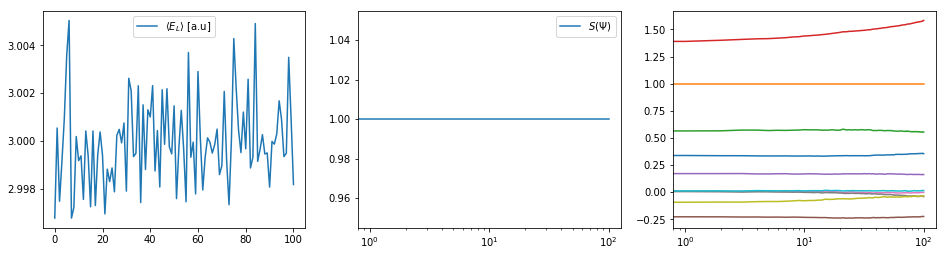

In [23]:
plot_training(psi_energies_2, psi_symmetries_2, np.array(psi_parameters_2)[:, :10])


In [22]:
compute_statistics_for_series(
    [H1.local_energy(psi_sampler.next_configuration(), psi) for _ in range(2 ** 21)],
    method="blocking",
)


{'mean': 3.0002513142537826,
 'max': 3.3081532562591836,
 'min': 2.96977189354779,
 'var': 8.47390089169847e-05,
 'std': 0.00920537934671813,
 'sem': 0.00010171224195359211,
 'CI': (3.0000519324606647, 3.0004506960469004)}

## Simple gaussian + Pade Jastrow + DNN + InputSorter


In [36]:
simple_gaussian = SimpleGaussian(alpha=0.5)
jastrow = JastrowPade(alpha=1, beta=0.4)
layers = [
    DenseLayer(P * D, 64, activation=tanh, scale_factor=0.001),
    DenseLayer(64, 32, activation=tanh),
    DenseLayer(32, 16, activation=tanh),
    DenseLayer(16, 1, activation=exponential),
]
dnn = Dnn()
for l in layers:
    dnn.add_layer(l)
simple_and_jastrow = WavefunctionProduct(simple_gaussian, jastrow)
psi_total = WavefunctionProduct(simple_and_jastrow, dnn)
psi = InputSorter(psi_total)
psi_sampler = ImportanceSampler(system, psi, step_size=0.1)
psi_sampler.thermalize(1000)
psi_sampler.acceptance_rate

0.988

In [37]:
s = psi_sampler.next_configuration()


In [38]:
%timeit H1.local_energy(s, psi)

75.3 µs ± 192 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
%timeit H1.local_energy(s, simple_gaussian)

1.36 µs ± 5.54 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [17]:
%timeit H1.local_energy(s, jastrow)

1.41 µs ± 4.43 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [18]:
%timeit H1.local_energy(s, dnn)

53 µs ± 871 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
%timeit H1.local_energy(s, psi_total)

65.7 µs ± 1.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


EnergyCallback(iter=0): 3.0015453858305245
EnergyCallback(iter=200): 3.0001212240609965
EnergyCallback(iter=400): 2.9933832832400897
EnergyCallback(iter=600): 2.9970318689813245
EnergyCallback(iter=800): 2.9974889865340244
EnergyCallback(iter=1000): 2.997221611034424
EnergyCallback(iter=1200): 2.998062244469898
EnergyCallback(iter=1400): 2.998346983898584
EnergyCallback(iter=1600): 2.9993018706435244
EnergyCallback(iter=1800): 2.999207588678959
EnergyCallback(iter=2000): 2.998714039752793
EnergyCallback(iter=2200): 2.9991073218863353
EnergyCallback(iter=2400): 2.9994316318883096
EnergyCallback(iter=2600): 2.9994393520136544
EnergyCallback(iter=2800): 2.9994247145570228
EnergyCallback(iter=3000): 2.999524289930053
EnergyCallback(iter=3200): 2.9987169779917107
EnergyCallback(iter=3400): 2.9991629610544472
EnergyCallback(iter=3600): 2.9992712395489014
EnergyCallback(iter=3800): 2.999960470933973
EnergyCallback(iter=4000): 2.999552391518793
EnergyCallback(iter=4200): 2.9992949315766406
Ene

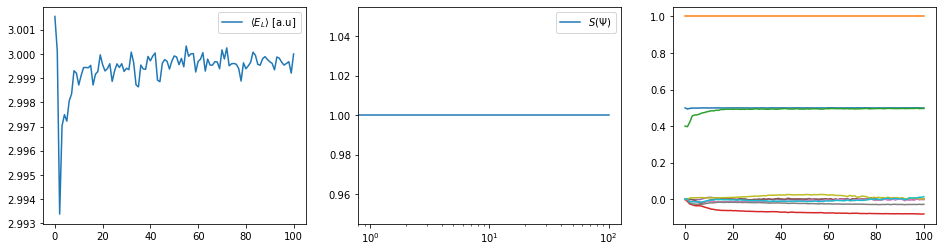

In [39]:
psi_energies = EnergyCallback(samples=50000, verbose=True)
psi_symmetries = SymmetryCallback(samples=10)
psi_parameters = ParameterCallback()

train(
    psi,
    H1,
    psi_sampler,
    iters=20000,
    samples=1000,
    gamma=0.0,
    optimizer=AdamOptimizer(len(psi.parameters)),
    call_backs=(psi_energies, psi_symmetries, psi_parameters),
)
plot_training(psi_energies, psi_symmetries, np.array(psi_parameters)[:, :10])


In [78]:
compute_statistics_for_series(
    H1.local_energy_array(psi_sampler, psi, 2 ** 22), method="blocking"
)

{'mean': 2.999988617561665,
 'max': 3.002379116612305,
 'min': 2.993445036727185,
 'var': 4.537860642014255e-07,
 'std': 0.0006736364480945383,
 'sem': 5.262945365535765e-06,
 'CI': (2.999978301616162, 2.999998933507168)}

In [41]:
compute_statistics_for_series(
    H1.local_energy_array(psi_sampler, psi, 2 ** 22), method="blocking"
)

{'mean': 2.999884238164263,
 'max': 3.0021185378568584,
 'min': 2.996845818447002,
 'var': 3.441517002884692e-07,
 'std': 0.0005866444411127316,
 'sem': 6.481962240530688e-06,
 'CI': (2.999871531874149, 2.9998969444543775)}

In [30]:
psi_sampler.acceptance_rate

0.9870382363873864

In [59]:
6- 2.999239142909979

3.000760857090021

In [80]:
6 -2.999988617561665

3.000011382438335

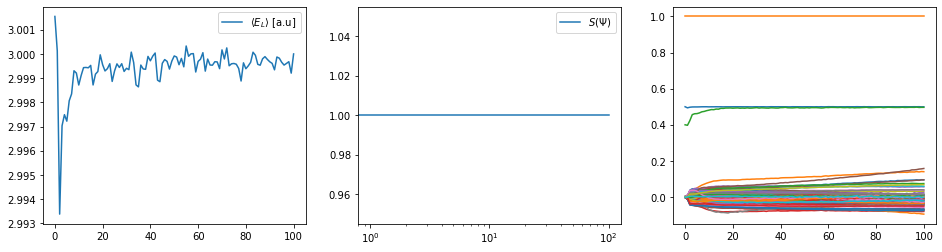

In [40]:
plot_training(psi_energies, psi_symmetries, np.array(psi_parameters)[:, :100])
